In [631]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [632]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage.data import rocket

In [633]:
import stretchablecorr as sc

(427, 640, 3)
(150, 322)


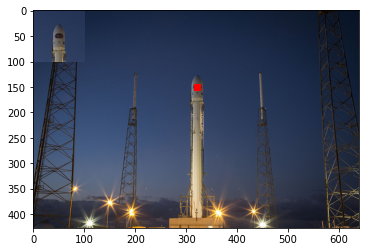

In [634]:
# ======
#  Crop
# ======
x, y = (322, 150)
plt.imshow(rocket());
print(rocket().shape)
plt.plot(x, y, 'sr');
C, ij = sc.crop(rocket(), (x, y), 50)
plt.imshow(C);
print(ij)

In [635]:
C, ij = sc.crop(rocket(), (322.2, 150.8), 50)
print(ij)

(151, 322)


In [636]:
# ============
#  get shifts
# ============

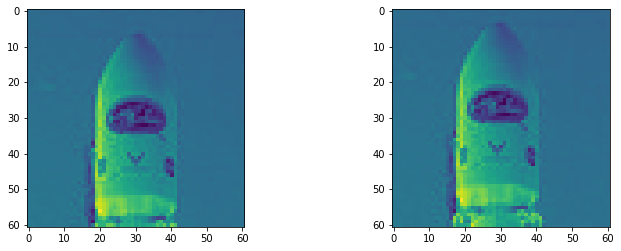

In [637]:
I = rocket().mean(axis=2)

window_half_size = 30
A, ij = sc.crop(I, (322, 150), window_half_size)
B, ij = sc.crop(I, (323, 153), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);
# true shifts  = -1, -3

In [638]:
sc.get_shifts(A, B, window_half_size, window_half_size,
               window_half_size=15,
               offset=(0.0, 0.0),
               coarse_search=False,
               upsample_factor=100,
               method='skimage')

(array([-1.01, -2.93]), [0.11381233475481252, -1.8345391167679188e-18])

In [639]:
sc.get_shifts(A, B, window_half_size, window_half_size,
               window_half_size=10,
               offset=(0.0, 0.0),
               coarse_search=True,
               upsample_factor=100,
               method='skimage')

(array([-1., -3.]), [1.8250120749944284e-08, -0.0])

In [640]:
sc.get_shifts(A, B, window_half_size, window_half_size,
               window_half_size=10,
               coarse_search=True,
               method='opti')

(array([-1., -3.]), [20.97617696340303, 0.3997730495540406])

### Benchmark

In [641]:
%%timeit
sc.get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=True,
           method='opti')

# 2.1 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 1.88 ms ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

1.97 ms ± 67.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [652]:
%%timeit
sc.get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=15,
           upsample_factor=10,
           coarse_search=False,
           method='skimage')

# upsample 100: 4.19 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# upsample 50:  1.16 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# upsample10:    800 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

800 µs ± 4.12 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [650]:
%%timeit
sc.get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=15,
           coarse_search=False,
           phase=False,
           method='opti')

# 3.09 ms ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 1.25 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 766 µs ± 140 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)  with jit
# 1.04 ms ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each) with jit

1.04 ms ± 5.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [644]:
%%timeit
sc.get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           upsample_factor=100,
           coarse_search=False,
           method='skimage')

2.97 ms ± 97.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Error estimation

In [28]:
cube, image_names = sc.load_image_sequence('./images/HS2_01/')

Load images from ./images/HS2_01/...
Image sequence:
 24 frames , 1392*1024 pixels , memory size: 261 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  60p000278.TIF


In [384]:
def custom_entropy(A):
    p = (A - A.min())/A.ptp()
    p = p/np.sum(p)
    p = p[p>0]
    return -np.sum( p*np.log(p) )/np.log(A.size)

def scd_moment(A, x, y):
    i, j = np.arange(A.shape[0]), np.arange(A.shape[1])
    i_grid, j_grid = np.meshgrid(i, j)
    pi = (i_grid - y)**2
    pj = (j_grid - x)**2
    d = np.sqrt(pi + pj)
    return np.average(d, weights=A)

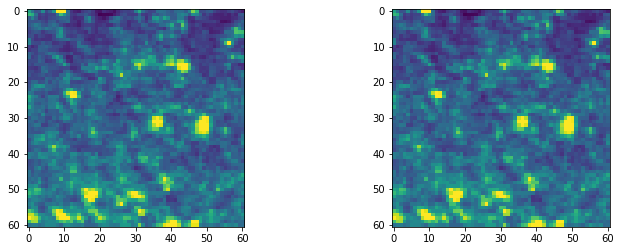

In [475]:
I = cube[4]

window_half_size = 30
A, ij = sc.crop(I, (222, 150), window_half_size)
B, ij = sc.crop(I, (222, 150), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [303]:
A = np.zeros(shape)+1
A[10, 10] = 2
B = np.zeros(shape)+1
B[15, 15] = 3

In [441]:
shape = (61, 61)
A = np.random.randn(*shape)
B = np.random.randn(*shape)#np.ones_like(A)
print(np.sum(A))

-97.01070422882496


In [466]:
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(A, B, upsamplefactor=1, phase=False)
dx, dy, err = get_shifts(A, B, *np.array(A.shape)/2,
           window_half_size=14,
           coarse_search=False,
           phase=False,
           method='opti')

In [467]:
i_grid, j_grid = np.meshgrid(dy_span, dx_span)
pi = (i_grid - dy)**2
pj = (j_grid - dx)**2
d = np.sqrt(pi + pj)**(1/2)
print(np.average(d, weights=np.log(phase_corr)-np.log(phase_corr).min()))
print('f   ', res.fun)
print('max ', phase_corr.max())
print('mean', phase_corr.mean())
print('std ', phase_corr.std())
print((phase_corr.max() - phase_corr.mean())/phase_corr.std())
print(scd_moment(phase_corr, dx, dy))

4.4203375858590634
f    -17035622601.999994
max  17035622601.999998
mean 15998583783.782854
std  88576968.00457875
11.707770559086386
46.024437021676604


In [468]:
ddx = np.diff(phase_corr, axis=0)
ddy = np.diff(phase_corr, axis=1)

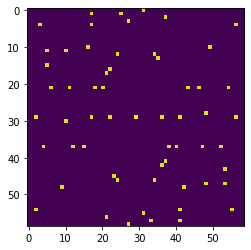

In [472]:
mask_x = np.sign( ddx[:-1, :] ) > np.sign( ddx[1:, :] )

mask_y = np.sign( ddy[:, :-1] ) > np.sign( ddy[:, 1:] )

peaks = mask_x[:, 1:-1]&mask_y[1:-1]
phase_corr_peak = phase_corr[1:-1, 1:-1].copy()
phase_corr_peak[~peaks] = 0
plt.imshow(phase_corr_peak);

In [470]:
from skimage.morphology import local_maxima

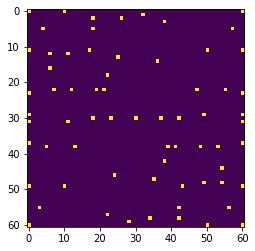

In [471]:
plt.imshow( local_maxima(phase_corr) )

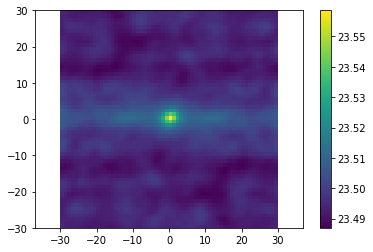

In [406]:
plt.pcolor(dx_span, dy_span, np.log(phase_corr));
plt.colorbar(); plt.axis('equal');

In [270]:
get_shifts(A, B, *np.array(A.shape)/2,
           window_half_size=14,
           coarse_search=False,
           phase=False,
           method='opti')

(5.0, 5.0, 4.078367216923564e-05)

In [32]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=5,
           coarse_search=False,
           method='opti')

(-0.05032008353871891, 1.224788309697461, -7.20748837107242)

In [527]:
def sample(window_half_size, sigma, phase):    
    B_prime = B + sigma*np.std(B)*np.random.randn(*B.shape)
    x, y = np.array(A.T.shape)/2
    dx, dy, err = get_shifts(A, B_prime, x, y,
                             window_half_size=window_half_size,
                             coarse_search=False,
                             phase=phase,
                             method='opti')
    return dx, dy, err

def estimate(window_half_size, sigma, phase, N=100):
    dxy_err = np.vstack([sample(window_half_size, sigma=sigma, phase=phase) for _ in range(N)])
    dxy = dxy_err[:, :2]
    eps_MC = np.sqrt(np.sum((dxy - dxy.mean(axis=0))**2, axis=1)).mean()
    
    err_estimate = dxy_err[:, 2]
    
    return eps_MC, err_estimate[0]

In [529]:
sigma_span = np.logspace(-1, 3, 15)
errs = np.vstack([estimate(10, s, phase=True, N=100) for s in sigma_span])

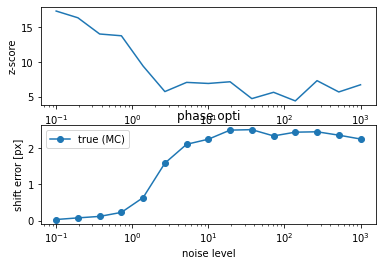

In [530]:
fig, (ax1, ax2) = plt.subplots(2, )
plt.title('phase opti')
ax1.semilogx(sigma_span, errs[:, 1], label='estimate')
ax1.set_ylabel('z-score');
ax2.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
ax2.set_ylabel('shift error [px]');
plt.legend(); 
plt.xlabel('noise level');

In [480]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=False, N=100) for s in sigma_span])

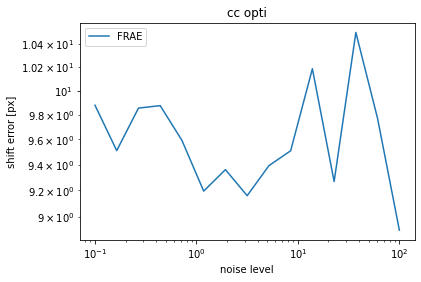

In [481]:
plt.title('cc opti')
plt.loglog(sigma_span, 1/errs[:, 1], label='FRAE')
#plt.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');

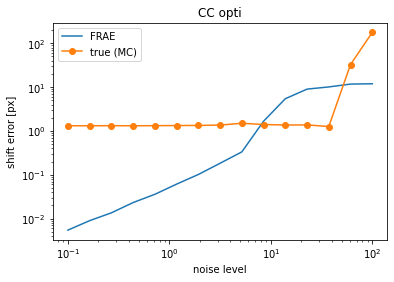

In [100]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=False, N=100) for s in sigma_span])

plt.title('CC opti')
plt.loglog(sigma_span, errs[:, 0], label='FRAE')
plt.loglog(sigma_span, errs[:, 1],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');

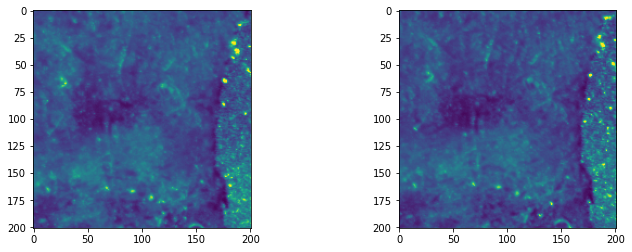

In [621]:
I = cube[0]
J = cube[10]
window_half_size = 100
x, y = 100, 106
A, ij = sc.crop(I, (x, y), window_half_size)
B, ij = sc.crop(J, (x, y), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [628]:
window_half_size_span = np.arange(5, 70, 5)
res = [get_shifts(I, J, x, y,
           window_half_size=whs,
           coarse_search=True,
           phase=True,
           method='opti')
      for whs in window_half_size_span]

In [629]:
err = [row[1] for row in res]
err = np.vstack(err)

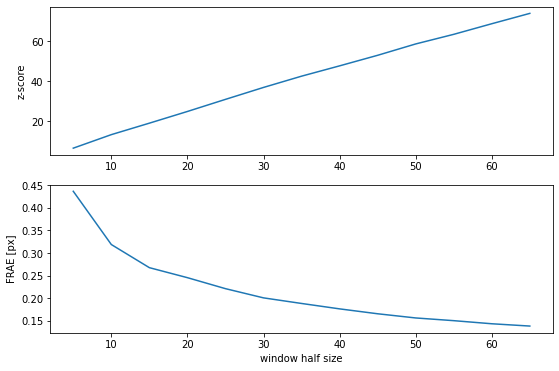

In [630]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6))
ax1.plot(window_half_size_span, err[:, 0]);
ax2.plot(window_half_size_span, err[:, 1]);

ax1.set_ylabel('z-score');
ax2.set_ylabel('FRAE [px]');
plt.xlabel('window half size');

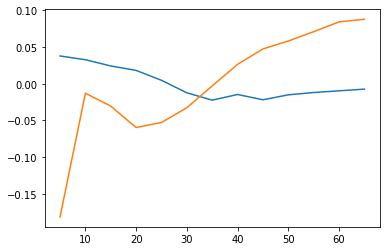

In [581]:
plt.plot(window_half_size_span, res[:, 0]-res[:, 0].mean());
plt.plot(window_half_size_span, res[:, 1]-res[:, 1].mean());

z_score 7.659085622138768


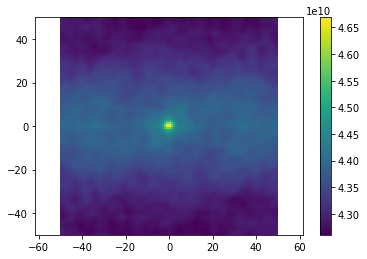

In [499]:
window_half_size = 50
A, ij = sc.crop(I, (232, 150), window_half_size)
B, ij = sc.crop(J, (232, 150), window_half_size)
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(A, B, upsamplefactor=1, phase=False)
print('z_score', (phase_corr.max()-phase_corr.mean())/phase_corr.std())
plt.pcolor(dx_span, dy_span, phase_corr);
plt.colorbar(); plt.axis('equal');

In [494]:
def sample(window_half_size, sigma, phase):    
    x, y = np.array(A.T.shape)/2
    dx, dy, err = get_shifts(A, B_prime, x, y,
                             window_half_size=window_half_size,
                             coarse_search=False,
                             phase=phase,
                             method='opti')
    return dx, dy, err

def estimate(window_half_size, sigma, phase, N=100):
    dxy_err = np.vstack([sample(window_half_size, sigma=sigma, phase=phase) for _ in range(N)])
    dxy = dxy_err[:, :2]
    eps_MC = np.sqrt(np.sum((dxy - dxy.mean(axis=0))**2, axis=1)).mean()
    
    err_estimate = dxy_err[:, 2]
    
    return eps_MC, err_estimate[0]